In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
import cmath
from datetime import datetime
from kneed import KneeLocator
from matplotlib import colors
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from neural_analysis.matIO import loadmat
from neural_analysis import spectra
from nolitsa import delay
import numpy as np
import os
import pandas as pd
import re
import scipy
from sdeint import itoint
from scipy.integrate import odeint
from scipy.signal import butter, lfilter
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from statsmodels.tsa.api import AutoReg, VAR
import sys
import time
from tqdm.auto import tqdm
import traceback as tb

plt.style.use('../../sci_style.py')

sys.path.append('../../..')
from iaaft import surrogates
from dynamical_systems_models import construct_dictionary, embed_signal, perform_stability_analysis, get_stability_results, compute_EDMD, predict_EDMD, compute_VAR_p, compute_VAR_p_over_lamb, predict_VAR_p
from nld_utils import calculate_fnn_stat, get_nn_indices
from plot import plot_individual_areas, plot_multipopulation
from up_down import get_up_down
from utils import compute_summary_statistics, get_data_class, get_result_path, load, load_session_data, run_window_selection, save

# Load Data

In [3]:
vdp_data = pd.read_pickle('__data__/vdp_full_data.pkl')

In [48]:
mu = 5
key = f'mu = {mu:.1f}'
signal = vdp_data['signals'][key]
dt_orig = vdp_data['dt']
dt = vdp_data['dt']*vdp_data['taus'][key]

# DMD

In [628]:
window_start = 0
window = 5000

In [629]:
train_signal = signal[window_start:window_start + window]
n = train_signal.shape[1]

In [630]:
p = 75

In [631]:
H = embed_signal(train_signal, p, 1, direction='reverse')

In [632]:
A = np.linalg.lstsq(H[:-1], H[1:], rcond=1e-14)[0].T

In [633]:
train_preds_chained = np.zeros(H.shape)
train_preds_chained[0] = H[0]
for t in range(1, H.shape[0]):
    train_preds_chained[t] = A @ train_preds_chained[t-1]

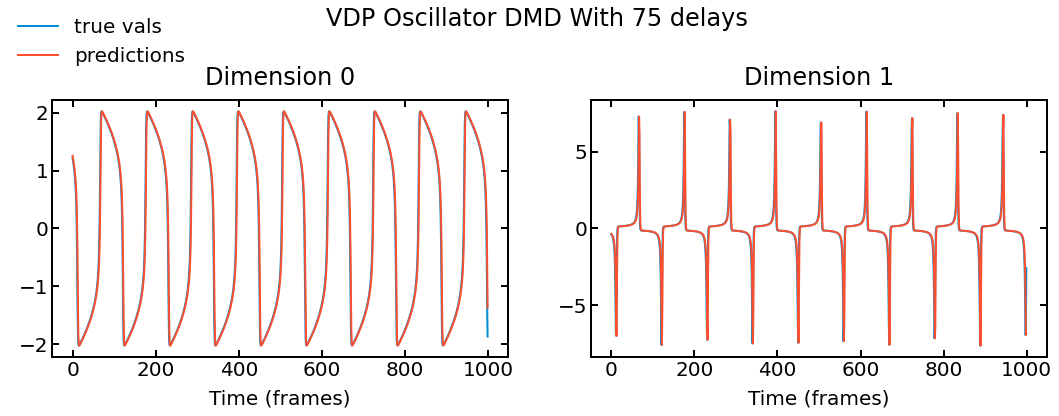

In [634]:
start = 0
end = 1000
fig = plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(train_signal[start + p:end + p, 0], label='true vals')
plt.plot(train_preds_chained[start:end, 0], label='predictions')
plt.xlabel('Time (frames)')
plt.title('Dimension 0')
plt.subplot(1, 2, 2)
plt.plot(train_signal[start + p:end + p, 1], label='true vals')
plt.plot(train_preds_chained[start:end, 1], label='predictions')
plt.xlabel('Time (frames)')
plt.title('Dimension 1')
plt.suptitle(f"VDP Oscillator DMD With {p} delays")
ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper left')
plt.tight_layout()
plt.show()

In [582]:
def compute_LLE(signal, A, T_pred=None, epsilon=1, dt=1, drop_initial=5, return_full=False):
    if T_pred is None:
        T_pred = signal.shape[0]
        
    d = signal.shape[1]
    w = np.zeros((T_pred, d))
    w_norms = np.zeros(T_pred)
    w_hat = np.zeros((T_pred, d))
    w[0] = np.random.randn(d)
    w_norms[0] = np.linalg.norm(w[0])
    w_hat[0] = w[0]/w_norms[0]
    
    for t in range(1, T_pred):
#         w[t] = A @(signal[t-1] + epsilon*w_hat[t-1]) - signal[t]
        w[t] = A @(signal[t-1] + epsilon*w_hat[t-1]) - (A @ signal[t - 1])
        w_norms[t] = np.linalg.norm(w[t])
        w_hat[t] = w[t]/w_norms[t]
    
    lle = np.log(w_norms[drop_initial:]/epsilon).sum()*(1/((w_norms.shape[0] - drop_initial)*dt))
    
    if return_full:
        return lle, w, w_norms, w_hat
    else:
        return lle

In [583]:
epsilon = 1e-1
T_pred = None
lle, w, w_norms, w_hat = compute_LLE(H, A, T_pred=T_pred, epsilon=epsilon, dt=dt, return_full=True)

In [584]:
lle

-0.0010267893689424657

In [585]:
def compute_lyapunov_spectrum(signal, A, dims=None, T_pred=None, epsilon=1, dt=1, drop_initial=5, return_full=False, verbose=False):
    if dims is None:
        dims = signal.shape[1]
    if T_pred is None:
        T_pred = signal.shape[0]
    
    d = signal.shape[1]
    w = np.zeros((T_pred, d, dims))
    w_norms = np.zeros((T_pred, dims))
    Q, R = np.linalg.qr(np.random.randn(d, dims))
    sign_diag = np.sign(np.diag(R))
    sign_diag[np.where(sign_diag == 0)] = 1
    sign_diag = np.diag(sign_diag)
    Q = np.dot(Q, sign_diag)
    R = np.dot(sign_diag, R)

    w[0] = Q
    w_norms[0] = np.diag(R)
    
    for t in tqdm(range(1, T_pred), disable=not verbose):
#         Q, R = np.linalg.qr(A @ (signal[t-1].reshape(-1, 1) + epsilon*w[t-1]) - signal[t].reshape(-1, 1))
        Q, R = np.linalg.qr(A @ (signal[t-1].reshape(-1, 1) + epsilon*w[t-1]) - (A @ signal[t - 1]).reshape(-1, 1))
        sign_diag = np.sign(np.diag(R))
        sign_diag[np.where(sign_diag == 0)] = 1
        sign_diag = np.diag(sign_diag)
        Q = np.dot(Q, sign_diag)
        R = np.dot(sign_diag, R)
        w[t] = Q
        w_norms[t] = np.diag(R)
    
    lyap_spec = np.log(w_norms[drop_initial:]/epsilon).sum(axis=0)*(1/((w_norms.shape[0] - drop_initial)*dt))

    if return_full:
        return lyap_spec, w, w_norms
    else:
        return lyap_spec

In [588]:
epsilon = 1e-5
dims = 100
T_pred = 5000
verbose = True
lyap_spec, w, w_norms = compute_lyapunov_spectrum(H, A, dims=dims, T_pred=T_pred, epsilon=epsilon, dt=dt, return_full=True, verbose=verbose)

  0%|          | 0/4999 [00:00<?, ?it/s]

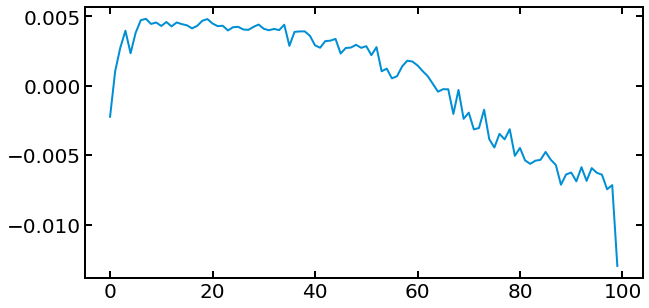

In [589]:
plt.plot(lyap_spec)

## Havok

In [590]:
U, S, Vh = np.linalg.svd(H.T, full_matrices=False)

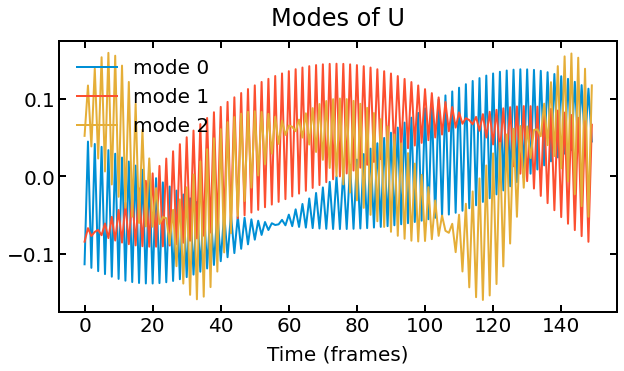

In [591]:
plt.plot(U[:, 0], label='mode 0')
plt.plot(U[:, 1], label='mode 1')
plt.plot(U[:, 2], label='mode 2')
plt.title('Modes of U')
plt.xlabel('Time (frames)')
plt.legend()
plt.show()

In [592]:
V = Vh.T

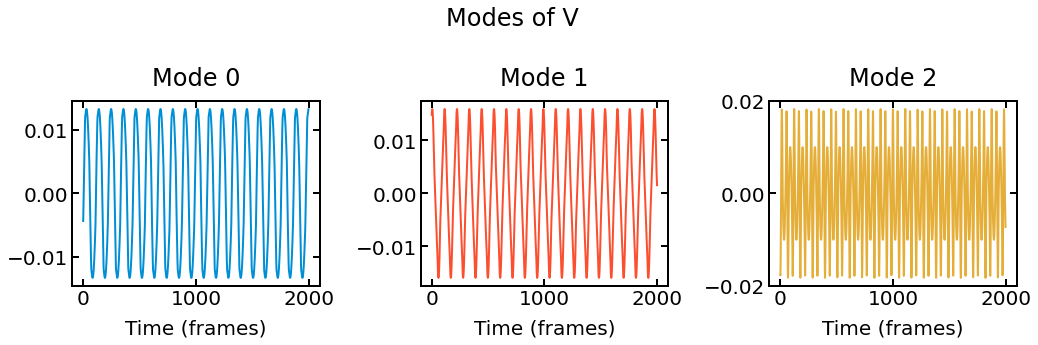

In [593]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(V[:2000, 0], label='mode 0')
plt.xlabel('Time (frames)')
plt.title('Mode 0')
plt.subplot(1, 3, 2)
plt.plot(V[:2000, 1], label='mode 1', c='C1')
plt.title('Mode 1')
plt.xlabel('Time (frames)')
plt.subplot(1, 3, 3)
plt.plot(V[:2000, 2], label='mode 2', c='C2')
plt.title('Mode 2')
plt.suptitle('Modes of V')
plt.xlabel('Time (frames)')
# plt.legend()
plt.tight_layout()
plt.show()

In [594]:
knee = KneeLocator(np.arange(len(S)), S, S=60, curve='convex', direction='decreasing').knee

In [595]:
r = 50

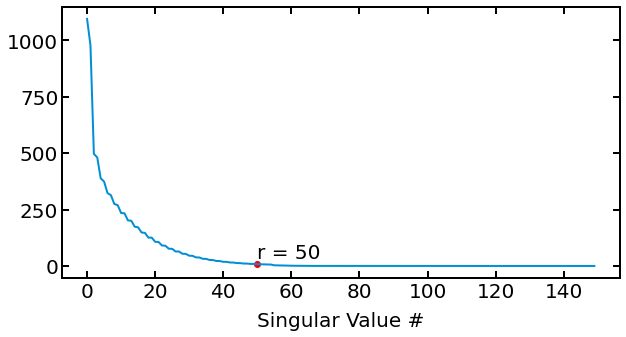

In [596]:
plt.plot(S)
plt.scatter(r, S[r], c='red')
plt.text(r, S[r]*4, f'r = {r}')
plt.xlabel("Singular Value #")
plt.show()

In [597]:
A = np.linalg.lstsq(V[:-1, :r], V[1:, :r], rcond=1e-14)[0].T

In [598]:
V_chained = np.zeros(V[:, :r].shape)
V_chained[0] = V[0, :r]
for t in range(1, V.shape[0]):
    V_chained[t] = A @ V_chained[t - 1]

In [599]:
S_mat = np.zeros(U.shape)
S_mat[np.arange(len(S)), np.arange(len(S))] = S

In [600]:
H_recon = (U @ S_mat[:, :r] @ V_chained[:, :r].T).T

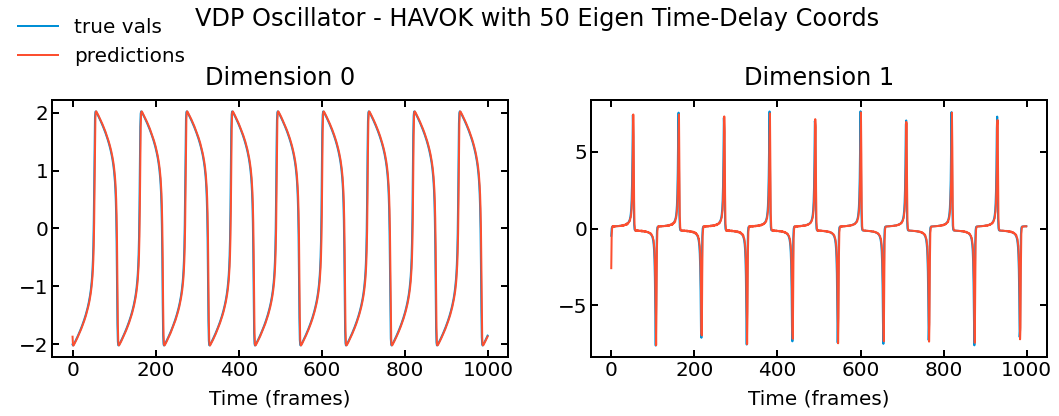

In [601]:
start = 0
end = 1000
fig = plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(train_signal[start + p:end + p, 0])
plt.plot(H_recon[start:end, 0])
plt.xlabel('Time (frames)')
plt.title('Dimension 0')
plt.subplot(1, 2, 2)
plt.plot(train_signal[start + p:end + p, 1], label='true vals')
plt.plot(H_recon[start:end, 1], label='predictions')
plt.xlabel('Time (frames)')
plt.title('Dimension 1')
plt.suptitle(f"VDP Oscillator - HAVOK with {r} Eigen Time-Delay Coords")
ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper left')
plt.tight_layout()
plt.show()

In [602]:
epsilon = 1e-1
T_pred = None
lle, w, w_norms, w_hat = compute_LLE(V[:, :r], A, T_pred=T_pred, epsilon=epsilon, dt=dt, return_full=True)

In [603]:
lle

-0.00016909230907861586

In [606]:
epsilon = 1e-12
dims = 50
T_pred = 5000
verbose = True
lyap_spec, w, w_norms = compute_lyapunov_spectrum(V[:, :r], A, dims=dims, T_pred=T_pred, epsilon=epsilon, dt=dt, return_full=True, verbose=verbose)

  0%|          | 0/4999 [00:00<?, ?it/s]

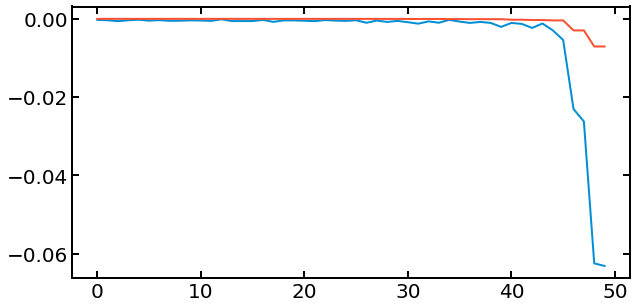

In [608]:
plt.plot(lyap_spec)
plt.plot(np.sort(np.real(np.log(np.linalg.eigvals(A))))[::-1])
plt.show()

### Method on Actual Space

In [510]:
U.shape

(150, 150)

In [542]:
S_mat = np.zeros(U.shape)
S_mat[np.arange(len(S)), np.arange(len(S))] = S
S_mat_inv = np.zeros(U.shape)
S_mat_inv[np.arange(len(S)), np.arange(len(S))] = 1/S

In [610]:
epsilon = 1e-12

In [611]:
w = np.random.randn(2)
w /= np.linalg.norm(w)

In [612]:
h0 = H[0].copy()
h0[:2] += epsilon*w

In [613]:
v_alt = S_mat_inv @ U.T @ h0

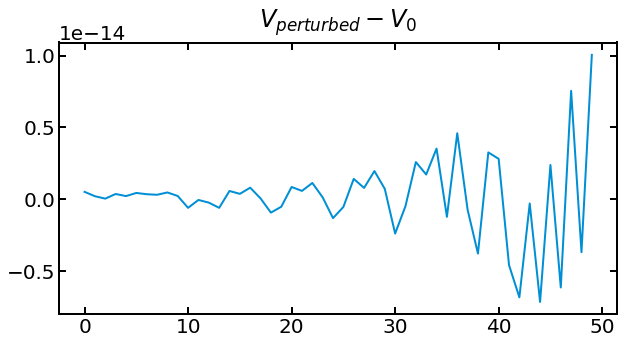

In [614]:
plt.plot((v_alt - V[0])[:50])
plt.title('$V_{perturbed} - V_0$')
plt.show()

In [616]:
perturbed_recon = U @ S_mat[:, :r] @ A @ v_alt[:r]
traj_recon = U @ S_mat[:, :r] @ A @ V[0, :r]

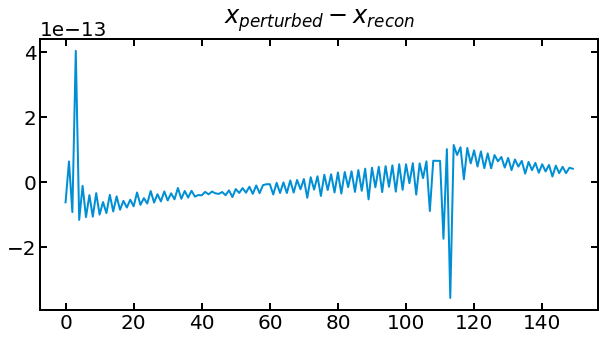

In [617]:
plt.plot(perturbed_recon - traj_recon)
plt.title("$x_{perturbed} - x_{recon}$")
plt.show()

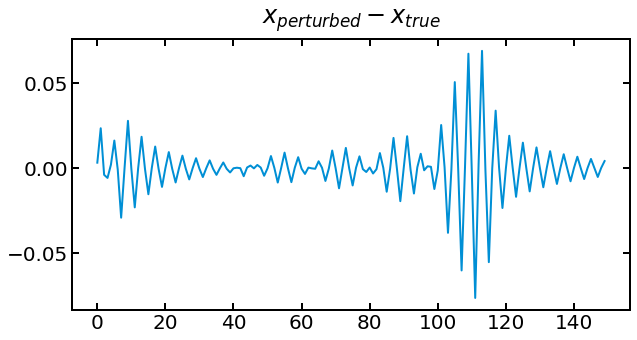

In [574]:
plt.plot(perturbed_recon - H[1])
plt.title("$x_{perturbed} - x_{true}$")
plt.show()

In [619]:
np.log(np.linalg.norm(perturbed_recon[:2] - traj_recon[:2])/epsilon)

-2.4205556009307796

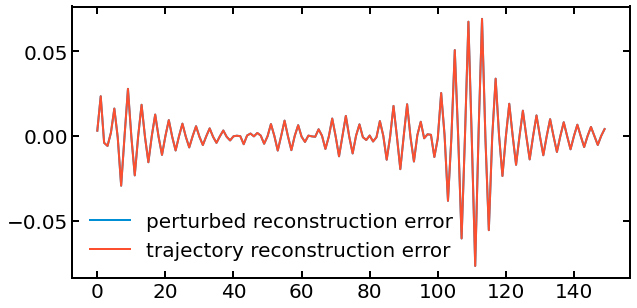

In [566]:
plt.plot(perturbed_recon - H[1], label='perturbed reconstruction error')
plt.plot(traj_recon - H[1], label='trajectory reconstruction error')
plt.legend()
plt.show()